In [1]:
import nltk
from collections import Counter
from string import punctuation
import string
from nltk.util import ngrams
from nltk import word_tokenize
from pprint import pprint 
from nltk.corpus import stopwords
from nltk.stem import StemmerI, RegexpStemmer, LancasterStemmer, ISRIStemmer, PorterStemmer, SnowballStemmer, RSLPStemmer
from nltk.stem import  WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
# import from nltk the functions that split a text into sentences and tokens
from six.moves import urllib

import re
import json
import pandas as pd
import numpy as np
from tqdm import tqdm

import os
import zipfile
import gensim
import logging

from itertools import cycle
from typing import List, Tuple

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interp


In [2]:
from tensorflow.python.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Flatten, Dense, Activation, Dropout, BatchNormalization 
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer

from tensorflow.keras.utils import to_categorical

from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans


from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

import nltk

import gensim
from gensim.models import Word2Vec
import gensim.downloader as api
import wordcloud

In [4]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Loading the data

In [5]:
label2id = {
    'NONE': 0,
    'EVIDENCE': 1,
    'CLAIM': 2}

def load_corpus(path, label_mapping=None):
    with open(path) as fp:
        corpus = json.load(fp)

    documents, texts, labels = [], [], []
    for abstract in corpus:
        documents.append(abstract)
        texts.append(corpus[abstract]['sentences'])
        if isinstance(label_mapping, dict):
            labels.append(
                [label_mapping[str(l).upper()]
                    for l in corpus[abstract]['labels']])
        else:
            labels.append([str(l).upper() for l in corpus[abstract]['labels']])

    assert len(texts) == len(labels)
    data = pd.DataFrame(
        zip(documents, texts, labels),
        columns=['document', 'sentences', 'labels'])

    return data

data = load_corpus('dataset_aueb_argument_v3.json') #, label_mapping=label2id)
print(f'Dataset length: {len(data)} abstracts')
data.sample(5)

Dataset length: 1017 abstracts


,document,sentences,labels
637,doi: 10.1096/fj.201801897r,[Phosphatidylglycerols are induced by gut dysb...,"[NEITHER, NEITHER, NEITHER, NEITHER, EVIDENCE,..."
600,doi: 10.1093/eurheartj/ehw260,[Catheter ablation in patients with persistent...,"[NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ..."
662,doi: 10.1103/physreve.93.052420,[Bispectral pairwise interacting source analys...,"[NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ..."
612,doi: 10.1093/europace/euy226,[Electrocardiogram phenotypes in hypertrophic ...,"[NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ..."
283,doi: 10.1016/s1474-4422(18)30054-1,[Stage at which riluzole treatment prolongs su...,"[NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ..."


In [6]:
data2 = load_corpus('dataset.json') #, label_mapping=label2id)
print(f'Dataset length: {len(data2)} abstracts')
data2.sample(5)

Dataset length: 1669 abstracts


,document,sentences,labels
483,GPQ_G6B2_PMID_28479623.txt,[Under-five mortality according to maternal su...,"[NONE, NONE, NONE, NONE, NONE, NONE, EVIDENCE,..."
890,NST_G7B2_S0019103514006022.txt,[Variability of the martian seasonal CO2 cap e...,"[NONE, NONE, NONE, NONE, NONE, NONE, EVIDENCE,..."
299,FGP_G3B4_PMID31366335.txt,"[Frequency, characteristics and hospital outco...","[NONE, NONE, NONE, NONE, NONE, NONE, EVIDENCE,..."
472,GOQ_G6B3_PMID-25560097.txt,[Pregnancy-related mortality in the United Sta...,"[NONE, NONE, NONE, NONE, NONE, NONE, NONE, EVI..."
1232,15705087,"[Brachytherapy-related dysuria., To evaluate ...","[NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON..."


* Combining both datasets

In [7]:
data_all = pd.concat([data, data2], ignore_index=True)
data_all

,document,sentences,labels
0,doi: 10.1001/jamaneurol.2017.2814,[Concordance Between Different Amyloid Immunoa...,"[NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ..."
1,doi: 10.1001/jamaneurol.2017.4913,[Association of Changes in Plasma Neurofilamen...,"[NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ..."
2,doi: 10.1002/2015gl067056,[Dynamically triggered slip leading to sustain...,"[NEITHER, NEITHER, NEITHER, EVIDENCE, EVIDENCE..."
3,doi: 10.1002/2015ms000564,[Impacts of parameterized orographic drag on t...,"[NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ..."
4,doi: 10.1002/2016gl069551,"[Climate model biases in jet streams, blocking...","[NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ..."
...,...,...,...
2681,17947826,[Long-term intraocular pressure control of tra...,"[NONE, NONE, EVIDENCE, EVIDENCE, CLAIM]"
2682,19383599,[Combined trabeculectomy and cataract extracti...,"[NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON..."
2683,17601060,[[Ocular hypotensive effect of 1% carteolol lo...,"[NONE, NONE, NONE, NONE, NONE, NONE, EVIDENCE,..."
2684,12383808,[A prospective randomized trial comparing intr...,"[NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON..."


In [8]:
data.head(4)

,document,sentences,labels
0,doi: 10.1001/jamaneurol.2017.2814,[Concordance Between Different Amyloid Immunoa...,"[NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ..."
1,doi: 10.1001/jamaneurol.2017.4913,[Association of Changes in Plasma Neurofilamen...,"[NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ..."
2,doi: 10.1002/2015gl067056,[Dynamically triggered slip leading to sustain...,"[NEITHER, NEITHER, NEITHER, EVIDENCE, EVIDENCE..."
3,doi: 10.1002/2015ms000564,[Impacts of parameterized orographic drag on t...,"[NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ..."


In [9]:
data2.head(5)

,document,sentences,labels
0,DEI_G2B1_15.txt,[Gender Differences in Anxiety and Depression ...,"[NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON..."
1,DEI_G2B1_23.txt,"[Women's economic empowerment, participation i...","[NONE, NONE, NONE, NONE, NONE, NONE, NONE, EVI..."
2,DEI_G2B1_24.txt,[Forced sterilization of women as discriminati...,"[NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON..."
3,DEI_G2B1_31.txt,[Relationship of gender differences in prefere...,"[NONE, NONE, NONE, NONE, NONE, EVIDENCE, CLAIM]"
4,DEI_G2B1_39.txt,"[Women’s Assessments of Gender Equality, Abstr...","[NONE, NONE, NONE, NONE, EVIDENCE, EVIDENCE, C..."


In [10]:
data_all

,document,sentences,labels
0,doi: 10.1001/jamaneurol.2017.2814,[Concordance Between Different Amyloid Immunoa...,"[NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ..."
1,doi: 10.1001/jamaneurol.2017.4913,[Association of Changes in Plasma Neurofilamen...,"[NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ..."
2,doi: 10.1002/2015gl067056,[Dynamically triggered slip leading to sustain...,"[NEITHER, NEITHER, NEITHER, EVIDENCE, EVIDENCE..."
3,doi: 10.1002/2015ms000564,[Impacts of parameterized orographic drag on t...,"[NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ..."
4,doi: 10.1002/2016gl069551,"[Climate model biases in jet streams, blocking...","[NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ..."
...,...,...,...
2681,17947826,[Long-term intraocular pressure control of tra...,"[NONE, NONE, EVIDENCE, EVIDENCE, CLAIM]"
2682,19383599,[Combined trabeculectomy and cataract extracti...,"[NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON..."
2683,17601060,[[Ocular hypotensive effect of 1% carteolol lo...,"[NONE, NONE, NONE, NONE, NONE, NONE, EVIDENCE,..."
2684,12383808,[A prospective randomized trial comparing intr...,"[NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON..."


* Counting total claims

In [11]:
total_claims = 0
for i in range(len(data_all)):
    for j in range(len(data_all['labels'][i])):
        if data_all['labels'][i][j] == 'CLAIM':
            total_claims += 1
total_claims

3419

In [12]:
incr = 0
for i in range(len(data_all)):
    if data_all['labels'][i][-1] == 'CLAIM':
        incr += 1


print('Number of abstracts that have the last sentence as Claims are:', incr)
print('Total number of abstracts is:', len(data_all))
print('Total number of claims is:', total_claims)

print('Percent is: {:.3f} %'.format(incr/len(data_all)*100))

Number of abstracts that have the last sentence as Claims are: 1550
Total number of abstracts is: 2686
Total number of claims is: 3419
Percent is: 57.707 %


In [13]:
#@title Split to sentences
sentences = data['sentences'].explode().reset_index().rename(
    columns={'index': 'doc_id', 'sentences': 'sentence'})
sentences


,doc_id,sentence
0,0,Concordance Between Different Amyloid Immunoas...
1,0,Importance Visual assessment of amyloid positr...
2,0,Several immunoassays have been developed to me...
3,0,The agreement between CSF Aβ42 measures from d...
4,0,Objective To determine the concordance between...
...,...,...
10570,1016,"Instead, SBPs sample a range of conformations ..."
10571,1016,Certain non-transported ligands leave the stru...
10572,1016,"Intriguingly, in some cases, similar SBP confo..."
10573,1016,"In this case, the inability for transport aris..."


In [14]:
#@title and the corresponding labels
labels = data['labels'].explode().reset_index().rename(
    columns={'index': 'doc_id', 'labels': 'label'})
labels

,doc_id,label
0,0,NEITHER
1,0,NEITHER
2,0,NEITHER
3,0,NEITHER
4,0,NEITHER
...,...,...
10570,1016,NEITHER
10571,1016,NEITHER
10572,1016,NEITHER
10573,1016,NEITHER


In [15]:
#@title Split to sentences
sentences2 = data2['sentences'].explode().reset_index().rename(
    columns={'index': 'doc_id', 'sentences': 'sentence'})
sentences2


,doc_id,sentence
0,0,Gender Differences in Anxiety and Depression b...
1,0,Abstract
2,0,Background/aims: The aim of this prospective s...
3,0,"Methods: AUD severity, state and trait anxiety..."
4,0,Follow-up assessments were performed at 6 and ...
...,...,...
21424,1668,No statistically significant difference in con...
21425,1668,Latanoprost 0.005% once daily reduced IOP more...
21426,1668,Latanoprost had no statistically or clinically...
21427,1668,There was no difference in hyperemia between t...


In [16]:
#@title and the corresponding labels
labels2 = data2['labels'].explode().reset_index().rename(
    columns={'index': 'doc_id', 'labels': 'label'})
labels2

,doc_id,label
0,0,NONE
1,0,NONE
2,0,NONE
3,0,NONE
4,0,NONE
...,...,...
21424,1668,EVIDENCE
21425,1668,NONE
21426,1668,CLAIM
21427,1668,CLAIM


In [17]:
labels2['label'] = labels2['label'].replace(['NONE'], 'NEITHER')
labels2

,doc_id,label
0,0,NEITHER
1,0,NEITHER
2,0,NEITHER
3,0,NEITHER
4,0,NEITHER
...,...,...
21424,1668,EVIDENCE
21425,1668,NEITHER
21426,1668,CLAIM
21427,1668,CLAIM


* Concatinating the sentences and the labels of the second dataset (data2)

In [18]:
df_concat2 = pd.concat([sentences2, labels2], axis=1)

print(df_concat2)

       doc_id                                           sentence  doc_id  \
0           0  Gender Differences in Anxiety and Depression b...       0   
1           0                                           Abstract       0   
2           0  Background/aims: The aim of this prospective s...       0   
3           0  Methods: AUD severity, state and trait anxiety...       0   
4           0  Follow-up assessments were performed at 6 and ...       0   
...       ...                                                ...     ...   
21424    1668  No statistically significant difference in con...    1668   
21425    1668  Latanoprost 0.005% once daily reduced IOP more...    1668   
21426    1668  Latanoprost had no statistically or clinically...    1668   
21427    1668  There was no difference in hyperemia between t...    1668   
21428    1668  Both concentrations of latanoprost reduced IOP...    1668   

          label  
0       NEITHER  
1       NEITHER  
2       NEITHER  
3       NEITHER

In [19]:
#@title Regroup document using doc_id
doc0_sents = sentences.query('doc_id==0')['sentence']
doc0_labels = labels.query('doc_id==0')['label']
for label, sent in zip(doc0_labels, doc0_sents):
    print(f'{str(label):10s} {sent}')

NEITHER    Concordance Between Different Amyloid Immunoassays and Visual Amyloid Positron Emission Tomographic Assessment
NEITHER    Importance Visual assessment of amyloid positron emission tomographic (PET) images has been approved by regulatory authorities for clinical use.
NEITHER    Several immunoassays have been developed to measure β-amyloid (Aβ) 42 in cerebrospinal fluid (CSF).
NEITHER    The agreement between CSF Aβ42 measures from different immunoassays and visual PET readings may influence the use of CSF biomarkers and/or amyloid PET assessment in clinical practice and trials.
NEITHER    Objective To determine the concordance between CSF Aβ42 levels measured using 5 different immunoassays and visual amyloid PET analysis.
NEITHER    Design, Setting, and Participants The study included 262 patients with mild cognitive impairment or subjective cognitive decline from the Swedish BioFINDER (Biomarkers for Identifying Neurodegenerative Disorders Early and Reliably) cohort (recruit

* Concating the sentences and the labels of the first dataset (data)

In [20]:
df_concat = pd.concat([sentences, labels], axis=1)

print(df_concat)

       doc_id                                           sentence  doc_id  \
0           0  Concordance Between Different Amyloid Immunoas...       0   
1           0  Importance Visual assessment of amyloid positr...       0   
2           0  Several immunoassays have been developed to me...       0   
3           0  The agreement between CSF Aβ42 measures from d...       0   
4           0  Objective To determine the concordance between...       0   
...       ...                                                ...     ...   
10570    1016  Instead, SBPs sample a range of conformations ...    1016   
10571    1016  Certain non-transported ligands leave the stru...    1016   
10572    1016  Intriguingly, in some cases, similar SBP confo...    1016   
10573    1016  In this case, the inability for transport aris...    1016   
10574    1016  Our results reveal the complex interplay betwe...    1016   

         label  
0      NEITHER  
1      NEITHER  
2      NEITHER  
3      NEITHER  
4 

In [21]:
df_concat2.head(20)

,doc_id,sentence,doc_id,label
0,0,Gender Differences in Anxiety and Depression b...,0,NEITHER
1,0,Abstract,0,NEITHER
2,0,Background/aims: The aim of this prospective s...,0,NEITHER
3,0,"Methods: AUD severity, state and trait anxiety...",0,NEITHER
4,0,Follow-up assessments were performed at 6 and ...,0,NEITHER
5,0,A between- and within-subjects analyses explor...,0,NEITHER
6,0,The predictive value of anxiety and depression...,0,NEITHER
7,0,Results: Females had higher levels of anxiety ...,0,NEITHER
8,0,Trait anxiety and depression significantly inc...,0,EVIDENCE
9,0,Both state and trait anxiety levels at the 6-m...,0,EVIDENCE


### Merging the two produced data frames in one named `df_concat`

In [22]:
df_concat = pd.concat([df_concat, df_concat2], ignore_index=True)
df_concat

,doc_id,sentence,doc_id,label
0,0,Concordance Between Different Amyloid Immunoas...,0,NEITHER
1,0,Importance Visual assessment of amyloid positr...,0,NEITHER
2,0,Several immunoassays have been developed to me...,0,NEITHER
3,0,The agreement between CSF Aβ42 measures from d...,0,NEITHER
4,0,Objective To determine the concordance between...,0,NEITHER
...,...,...,...,...
31999,1668,No statistically significant difference in con...,1668,EVIDENCE
32000,1668,Latanoprost 0.005% once daily reduced IOP more...,1668,NEITHER
32001,1668,Latanoprost had no statistically or clinically...,1668,CLAIM
32002,1668,There was no difference in hyperemia between t...,1668,CLAIM


In [23]:
df_concat.head(20)

,doc_id,sentence,doc_id,label
0,0,Concordance Between Different Amyloid Immunoas...,0,NEITHER
1,0,Importance Visual assessment of amyloid positr...,0,NEITHER
2,0,Several immunoassays have been developed to me...,0,NEITHER
3,0,The agreement between CSF Aβ42 measures from d...,0,NEITHER
4,0,Objective To determine the concordance between...,0,NEITHER
5,0,"Design, Setting, and Participants The study in...",0,NEITHER
6,0,Levels of CSF Aβ42 were analyzed using the cla...,0,NEITHER
7,0,Concentrations of CSF Aβ were assessed using a...,0,NEITHER
8,0,Main Outcomes and Measures The concordance of ...,0,EVIDENCE
9,0,"Results Of 262 participants (mean [SD] age, 70...",0,EVIDENCE


In [24]:
df_concat.shape

(32004, 4)

In [25]:
df_concat.columns = ['doc_id', 'sentence', 'doc_id2', 'label']

In [26]:
df_concat.columns

Index(['doc_id', 'sentence', 'doc_id2', 'label'], dtype='object')

In [27]:
df_concat = df_concat.drop('doc_id2', axis=1)  # df.columns is zero-based pd.Index

In [28]:
df_concat

,doc_id,sentence,label
0,0,Concordance Between Different Amyloid Immunoas...,NEITHER
1,0,Importance Visual assessment of amyloid positr...,NEITHER
2,0,Several immunoassays have been developed to me...,NEITHER
3,0,The agreement between CSF Aβ42 measures from d...,NEITHER
4,0,Objective To determine the concordance between...,NEITHER
...,...,...,...
31999,1668,No statistically significant difference in con...,EVIDENCE
32000,1668,Latanoprost 0.005% once daily reduced IOP more...,NEITHER
32001,1668,Latanoprost had no statistically or clinically...,CLAIM
32002,1668,There was no difference in hyperemia between t...,CLAIM


In [29]:
#getting a sense of the relative numbers of the labels
df_concat.drop(['sentence'],1).groupby(['label']).count()

,doc_id
label,
CLAIM,3419
EVIDENCE,6210
NEITHER,22375


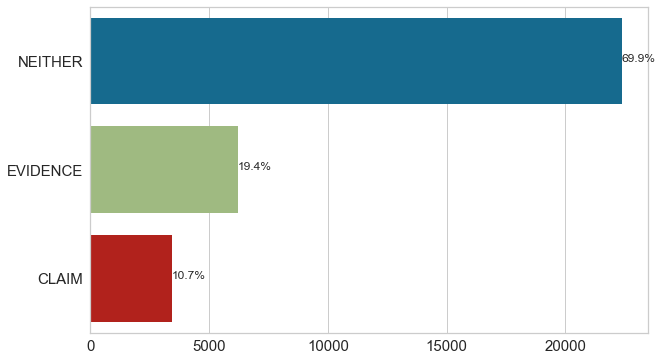

In [30]:
# ploting the cumulative counts of the three labels together with their respective percentages
import seaborn as sns
fig = plt.figure(figsize=(10,6))
ax = sns.countplot(y="label", data=df_concat)
total = len(df_concat)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.05
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
ax.tick_params(labelsize=15)
ax.set_xlabel("")
ax.set_ylabel("")
plt.show()

## Pre-Processing NLTK

* Import english stopwords

In [31]:
en_stop = stopwords.words('english')

* Setting the Lemmatizer (WordNet) of NLTK library

In [32]:
lemmatizer = WordNetLemmatizer()

### Defing the function that pre-process the sentences

* Removing characters that are not letters or numbers, removing stop words and obtaining the lemma of each token

In [33]:
def clean_sentence(sent):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', sent).lower()
    sentence = sentence.split(" ")      
    sentence = [word for word in sentence if word not in en_stop]
    sentence = [lemmatizer.lemmatize(word,pos='v') for word in sentence ] 
    sentence = [i for i in sentence if not i.isdigit()]
    sentence = " ".join(sentence)
    return sentence

* Creating the `clean_sent` column with the processed sentences

In [34]:
df_concat['clean_sent'] = df_concat['sentence'].apply(clean_sentence)
df_concat

,doc_id,sentence,label,clean_sent
0,0,Concordance Between Different Amyloid Immunoas...,NEITHER,concordance different amyloid immunoassays vis...
1,0,Importance Visual assessment of amyloid positr...,NEITHER,importance visual assessment amyloid positron ...
2,0,Several immunoassays have been developed to me...,NEITHER,several immunoassays develop measure βamyloid ...
3,0,The agreement between CSF Aβ42 measures from d...,NEITHER,agreement csf aβ42 measure different immunoass...
4,0,Objective To determine the concordance between...,NEITHER,objective determine concordance csf aβ42 level...
...,...,...,...,...
31999,1668,No statistically significant difference in con...,EVIDENCE,statistically significant difference conjuncti...
32000,1668,Latanoprost 0.005% once daily reduced IOP more...,NEITHER,latanoprost daily reduce iop effectively latan...
32001,1668,Latanoprost had no statistically or clinically...,CLAIM,latanoprost statistically clinically significa...
32002,1668,There was no difference in hyperemia between t...,CLAIM,difference hyperemia two regimens


## Splitting in Train-Test Data sets in 70-30%

In [35]:
X = df_concat['clean_sent']
X

0        concordance different amyloid immunoassays vis...
1        importance visual assessment amyloid positron ...
2        several immunoassays develop measure βamyloid ...
3        agreement csf aβ42 measure different immunoass...
4        objective determine concordance csf aβ42 level...
                               ...                        
31999    statistically significant difference conjuncti...
32000    latanoprost daily reduce iop effectively latan...
32001    latanoprost statistically clinically significa...
32002                    difference hyperemia two regimens
32003    concentrations latanoprost reduce iop least we...
Name: clean_sent, Length: 32004, dtype: object

In [36]:
y = df_concat['label']
y.head()

0    NEITHER
1    NEITHER
2    NEITHER
3    NEITHER
4    NEITHER
Name: label, dtype: object

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.30,
                                                    random_state=13,
                                                    stratify=y)

In [38]:
X_train.head()

24454    patients complete questionnaires visit intervi...
22646    addition previous study analyse sample large s...
11948    yet contradictory expectations gender equality...
20779    stabilize c rather c would save approximately ...
19729                                                  set
Name: clean_sent, dtype: object

In [39]:
X_train.shape

(22402,)

In [40]:
y_train.head()

24454    NEITHER
22646    NEITHER
11948    NEITHER
20779    NEITHER
19729    NEITHER
Name: label, dtype: object

In [41]:
y_train.shape

(22402,)

In [42]:

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print()

print()
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (22402,)
y_train shape: (22402,)


X_test shape: (9602,)
y_test shape: (9602,)


* Creating 2x Dataframes -> Claims & Evidence (of the Train Data set)

In [43]:
claims = X_train[y_train == 'CLAIM']
claims

30998    latanoprost timolol single treatments reduce i...
27716    conclude three cycle bep etoposide mgm2 suffic...
19048    finally study suggest regional cooperation exp...
25575    program care need extend spouses likely experi...
7806        variants could potentially alter drug efficacy
                               ...                        
5028     data highlight importance cellular context dis...
27670    whereas patients early alternate chemotherapy ...
21459    result reveal need policy measure aim encourag...
8582     believe progress make combination future study...
31256    latanoprost administer daily reduce intraocula...
Name: clean_sent, Length: 2393, dtype: object

In [44]:
corpora_claims = " ".join(claims)
print(corpora_claims[:1000])

latanoprost timolol single treatments reduce iop trough effect years japanese ntg patients show similar effect visual field performance conclude three cycle bep etoposide mgm2 sufficient therapy goodprognosis germ cell cancer administration chemotherapy days detrimental effect effectiveness bep regimen finally study suggest regional cooperation expedite transition nonrenewable renewable energy source facilitate expansion green bond market develop countries may prove helpful mitigate carbon emissions increase investment clean energy project program care need extend spouses likely experience multiple benefit intervention variants could potentially alter drug efficacy propose cells pass either mix unspecific intermediate progenitorlike state transdifferentiation vary degrees resemble state see development result large randomize trial use validate patientcompleted questionnaires show males main adverse effect sexual dysfunction main cause surgery pre also affect sexual aspects bowel functi

* Get tokens of the claims

In [45]:
tokens = word_tokenize(corpora_claims.lower())
print(tokens[:20])

['latanoprost', 'timolol', 'single', 'treatments', 'reduce', 'iop', 'trough', 'effect', 'years', 'japanese', 'ntg', 'patients', 'show', 'similar', 'effect', 'visual', 'field', 'performance', 'conclude', 'three']


In [46]:
count = Counter(tokens)
pprint(count.most_common(30))

[('patients', 368),
 ('result', 236),
 ('study', 233),
 ('treatment', 213),
 ('improve', 206),
 ('use', 182),
 ('increase', 176),
 ('change', 174),
 ('cancer', 173),
 ('conclusions', 168),
 ('suggest', 163),
 ('health', 160),
 ('find', 154),
 ('show', 151),
 ('may', 150),
 ('effect', 143),
 ('climate', 136),
 ('conclusion', 134),
 ('associate', 133),
 ('reduce', 125),
 ('women', 124),
 ('model', 123),
 ('need', 112),
 ('risk', 110),
 ('impact', 107),
 ('provide', 104),
 ('effective', 103),
 ('compare', 101),
 ('survival', 98),
 ('advance', 97)]


In [47]:
filtered = [w for w in tokens if w not in en_stop]

count_filtered = Counter(filtered)

pprint(count_filtered.most_common(20))

[('patients', 368),
 ('result', 236),
 ('study', 233),
 ('treatment', 213),
 ('improve', 206),
 ('use', 182),
 ('increase', 176),
 ('change', 174),
 ('cancer', 173),
 ('conclusions', 168),
 ('suggest', 163),
 ('health', 160),
 ('find', 154),
 ('show', 151),
 ('may', 150),
 ('effect', 143),
 ('climate', 136),
 ('conclusion', 134),
 ('associate', 133),
 ('reduce', 125)]


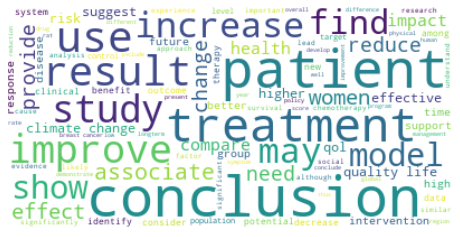

In [48]:
text = corpora_claims
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [49]:
wordcloud.to_file("claim_words.png")

* Lexicon with 25 most common words in the claims

In [50]:
lexicon_cl = count_filtered.most_common(25)
lexicon_cl

[('patients', 368),
 ('result', 236),
 ('study', 233),
 ('treatment', 213),
 ('improve', 206),
 ('use', 182),
 ('increase', 176),
 ('change', 174),
 ('cancer', 173),
 ('conclusions', 168),
 ('suggest', 163),
 ('health', 160),
 ('find', 154),
 ('show', 151),
 ('may', 150),
 ('effect', 143),
 ('climate', 136),
 ('conclusion', 134),
 ('associate', 133),
 ('reduce', 125),
 ('women', 124),
 ('model', 123),
 ('need', 112),
 ('risk', 110),
 ('impact', 107)]

In [51]:
my_keys_cl = [key for key, val in lexicon_cl]
my_keys_cl

['patients',
 'result',
 'study',
 'treatment',
 'improve',
 'use',
 'increase',
 'change',
 'cancer',
 'conclusions',
 'suggest',
 'health',
 'find',
 'show',
 'may',
 'effect',
 'climate',
 'conclusion',
 'associate',
 'reduce',
 'women',
 'model',
 'need',
 'risk',
 'impact']

In [52]:
X_test

5230                                                      
30396    median pfs months respectively cisplatin versu...
29960    ppxcarboplatin fail provide superior survival ...
8810     diverse cn54gp140 specific serum antibody resp...
31797    bimatoprost fix combination latanoprost timolo...
                               ...                        
17180    aim study evaluate daily pm10 ozone potential ...
21204    abstract microhydropower mhp present new oppor...
16644    adjust rat obtain control vshaped cohort effec...
5447     contact davidgloriamsundkudk supplementary inf...
29769    despite increase amount time individuals spend...
Name: clean_sent, Length: 9602, dtype: object

In [53]:
X_test = X_test.reset_index()

In [54]:
X_test

,index,clean_sent
0,5230,
1,30396,median pfs months respectively cisplatin versu...
2,29960,ppxcarboplatin fail provide superior survival ...
3,8810,diverse cn54gp140 specific serum antibody resp...
4,31797,bimatoprost fix combination latanoprost timolo...
...,...,...
9597,17180,aim study evaluate daily pm10 ozone potential ...
9598,21204,abstract microhydropower mhp present new oppor...
9599,16644,adjust rat obtain control vshaped cohort effec...
9600,5447,contact davidgloriamsundkudk supplementary inf...


In [55]:
y_test = y_test.reset_index()
y_test

,index,label
0,5230,NEITHER
1,30396,EVIDENCE
2,29960,CLAIM
3,8810,EVIDENCE
4,31797,NEITHER
...,...,...
9597,17180,NEITHER
9598,21204,NEITHER
9599,16644,NEITHER
9600,5447,NEITHER


### Intuitive Baseline Classifier for Assigning Sentences as Claim based on lexicon with claims related words

In [56]:
prediction = ['OTHER']*len(X_test)
for i in range(len(X_test)):
    list_of_words = X_test.clean_sent[i].split()
    for word in list_of_words:
        if word in my_keys_cl:
            prediction[i] = 'CLAIM'
            break
        else:
            prediction[i] = 'OTHER'
prediction[:10]

['OTHER',
 'OTHER',
 'CLAIM',
 'OTHER',
 'CLAIM',
 'CLAIM',
 'CLAIM',
 'CLAIM',
 'CLAIM',
 'CLAIM']

### Creating Confusion Matrix components manually

In [57]:
FP = 0
for i in range(len(X_test)):
    if prediction[i] == 'CLAIM' and (y_test.label[i] == 'NEITHER' or y_test.label[i] == 'EVIDENCE'):
        FP = FP + 1
FP

5197

In [58]:
TP = 0
for i in range(len(X_test)):
    if prediction[i] == 'CLAIM' and y_test.label[i] == 'CLAIM':
        TP = TP + 1
TP

815

In [59]:
FN = 0
for i in range(len(X_test)):
    if prediction[i] == 'OTHER' and y_test.label[i] == 'CLAIM':
        FN = FN + 1
FN

211

In [60]:
TN = 0
for i in range(len(X_test)):
    if prediction[i] == 'OTHER' and (y_test.label[i] == 'NEITHER' or y_test.label[i] == 'EVIDENCE'):
        TN = TN + 1
TN

3379

In [205]:
### ACCURACY TP + TN / TP + TN + FP + FN
accuracy_claim = (TP + TN)/(TP + TN + FP + FN)
print('Accuracy with dummy classifier for claims: ', accuracy_claim)

Accuracy with dummy classifier for claims:  0.5522807748385753


In [62]:
misclas_error = (FP + FN) / (TP + TN + FP + FN)
misclas_error

0.563215996667361

In [206]:
precision = TP / (TP + FP)
print('Precision with dummy classifier for claims: ', precision)

Precision with dummy classifier for claims:  0.26666666666666666


In [64]:
recall = TP / (TP + FN)
print('Recall with dummy classifier for claims: ', recall)

0.7943469785575049

In [207]:
f1_score = (2 * precision * recall) / (precision + recall)
print('F1-Score with dummy classifier for claims: ', f1_score)

F1-Score with dummy classifier for claims:  0.39305379076662433


### Bi-grams and Tri-grams for Claims

In [66]:
bigrams = [gram for gram in ngrams(tokens, 2)]
trigrams = [gram for gram in ngrams(tokens, 3)]

print()
print('First 10 Bi-grams')
pprint(bigrams[:10])

print(30*'-')
print('First 10 Tri-grams')
pprint(trigrams[:10])


First 10 Bi-grams
[('latanoprost', 'timolol'),
 ('timolol', 'single'),
 ('single', 'treatments'),
 ('treatments', 'reduce'),
 ('reduce', 'iop'),
 ('iop', 'trough'),
 ('trough', 'effect'),
 ('effect', 'years'),
 ('years', 'japanese'),
 ('japanese', 'ntg')]
------------------------------
First 10 Tri-grams
[('latanoprost', 'timolol', 'single'),
 ('timolol', 'single', 'treatments'),
 ('single', 'treatments', 'reduce'),
 ('treatments', 'reduce', 'iop'),
 ('reduce', 'iop', 'trough'),
 ('iop', 'trough', 'effect'),
 ('trough', 'effect', 'years'),
 ('effect', 'years', 'japanese'),
 ('years', 'japanese', 'ntg'),
 ('japanese', 'ntg', 'patients')]


In [67]:
top_trigrams = Counter(trigrams).most_common()
top_trigrams[:40]

[(('patients', 'advance', 'nsclc'), 12),
 (('breast', 'cancer', 'patients'), 11),
 (('improve', 'quality', 'life'), 9),
 (('head', 'neck', 'cancer'), 8),
 (('climate', 'change', 'impact'), 8),
 (('glaucoma', 'ocular', 'hypertension'), 8),
 (('female', 'genital', 'mutilation'), 8),
 (('healthrelated', 'quality', 'life'), 7),
 (('global', 'climate', 'change'), 6),
 (('advance', 'breast', 'cancer'), 6),
 (('generally', 'well', 'tolerate'), 6),
 (('impact', 'climate', 'change'), 6),
 (('renewable', 'energy', 'consumption'), 6),
 (('intimate', 'partner', 'violence'), 5),
 (('effective', 'reduce', 'iop'), 5),
 (('ispartof', 'locationengland', 'status'), 5),
 (('locationengland', 'status', 'publish'), 5),
 (('patients', 'advance', 'cancer'), 5),
 (('future', 'climate', 'change'), 5),
 (('quality', 'life', 'qol'), 5),
 (('road', 'traffic', 'injuries'), 4),
 (('metastatic', 'colorectal', 'cancer'), 4),
 (('cancer', 'patients', 'receive'), 4),
 (('liver', 'iron', 'content'), 4),
 (('electronic',

In [68]:
top_bigrams = Counter(bigrams).most_common()
top_bigrams[:20]

[(('climate', 'change'), 83),
 (('quality', 'life'), 81),
 (('breast', 'cancer'), 49),
 (('cancer', 'patients'), 40),
 (('patients', 'advance'), 36),
 (('well', 'tolerate'), 32),
 (('result', 'suggest'), 31),
 (('renewable', 'energy'), 29),
 (('find', 'suggest'), 22),
 (('overall', 'survival'), 22),
 (('advance', 'nsclc'), 20),
 (('mental', 'health'), 19),
 (('significantly', 'improve'), 19),
 (('study', 'suggest'), 18),
 (('public', 'health'), 17),
 (('patients', 'receive'), 17),
 (('study', 'demonstrate'), 17),
 (('study', 'show'), 16),
 (('prostate', 'cancer'), 15),
 (('result', 'indicate'), 14)]

##  The same procedure for Evidence

In [69]:
evidence = X_train[y_train == 'EVIDENCE']
evidence

12679    complications term perineal tear bleed inconti...
24895    neither gefitinib mgday improve overall surviv...
24714    grade neutropenia diarrhoea affect respectivel...
4155     substantial portion preindustrial 13001800 ce ...
18883    simulations minimize cost energy mix optimize ...
                               ...                        
26488    intrusive thoughts associate higher level symp...
31996    latanoprost daily reduce iop  sem effectively ...
29679    fludarabine consistently better treatment chop...
3299     first source observation measure greenness lan...
22217    however increase productivity climate change l...
Name: clean_sent, Length: 4347, dtype: object

In [70]:
corpora_evidence = " ".join(evidence)
corpora_evidence[:1000]

'complications term perineal tear bleed incontinence febrile illnesses register fgm neither gefitinib mgday improve overall survival compare methotrexate hazard ratio hr ci p  hr ci p  respectively grade neutropenia diarrhoea affect respectively patients treat cpt11  lfa 5fu substantial portion preindustrial 13001800\u2009ce variability multidecadal timescales attribute volcanic aerosol force simulations minimize cost energy mix optimize electricity storage mix batteries daily storage powertogasgastopower seasonal storage deteriorate followup women continue cchrt another main find persons social network significant effect whether individuals take protective action result enter simultaneously big five traits moderately associate overall health multiple r  first part study demonstrate realistic representation strong tc count obtain couple atmosphere ocean components hourly instead daily frequency hla influence fact specific igg production usually need cell help provide indirect evidence 

In [71]:
tokens_ev = word_tokenize(corpora_evidence.lower())
print(tokens_ev[:20])

['complications', 'term', 'perineal', 'tear', 'bleed', 'incontinence', 'febrile', 'illnesses', 'register', 'fgm', 'neither', 'gefitinib', 'mgday', 'improve', 'overall', 'survival', 'compare', 'methotrexate', 'hazard', 'ratio']


In [72]:
count_ev = Counter(tokens_ev)
pprint(count_ev.most_common(30))

[('p', 1101),
 ('group', 1080),
 ('patients', 740),
 ('ci', 504),
 ('months', 440),
 ('increase', 430),
 ('significant', 426),
 ('result', 409),
 ('significantly', 396),
 ('show', 355),
 ('compare', 330),
 ('higher', 305),
 ('respectively', 303),
 ('mean', 293),
 ('change', 278),
 ('treatment', 276),
 ('score', 273),
 ('find', 270),
 ('arm', 260),
 ('vs', 248),
 ('use', 247),
 ('survival', 241),
 ('difference', 233),
 ('control', 228),
 ('time', 225),
 ('associate', 223),
 ('level', 223),
 ('effect', 222),
 ('decrease', 222),
 ('women', 214)]


In [73]:
filtered_ev = [w for w in tokens_ev if w not in en_stop]

count_filtered_ev = Counter(filtered_ev)

pprint(count_filtered_ev.most_common(20))

[('p', 1101),
 ('group', 1080),
 ('patients', 740),
 ('ci', 504),
 ('months', 440),
 ('increase', 430),
 ('significant', 426),
 ('result', 409),
 ('significantly', 396),
 ('show', 355),
 ('compare', 330),
 ('higher', 305),
 ('respectively', 303),
 ('mean', 293),
 ('change', 278),
 ('treatment', 276),
 ('score', 273),
 ('find', 270),
 ('arm', 260),
 ('vs', 248)]


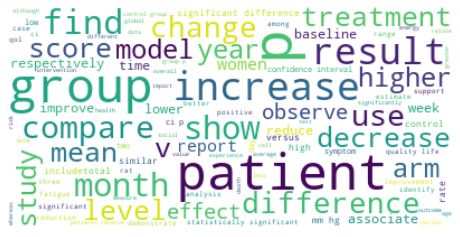

In [74]:
text = corpora_evidence
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [75]:
wordcloud.to_file("evidence_words.png")

* Lexicon with 25 most common words in Evidences

In [76]:
lexicon_ev = count_filtered_ev.most_common(25)
lexicon_ev

[('p', 1101),
 ('group', 1080),
 ('patients', 740),
 ('ci', 504),
 ('months', 440),
 ('increase', 430),
 ('significant', 426),
 ('result', 409),
 ('significantly', 396),
 ('show', 355),
 ('compare', 330),
 ('higher', 305),
 ('respectively', 303),
 ('mean', 293),
 ('change', 278),
 ('treatment', 276),
 ('score', 273),
 ('find', 270),
 ('arm', 260),
 ('vs', 248),
 ('use', 247),
 ('survival', 241),
 ('difference', 233),
 ('control', 228),
 ('time', 225)]

In [77]:
my_keys_ev = [key for key, val in lexicon_ev]
my_keys_ev

['p',
 'group',
 'patients',
 'ci',
 'months',
 'increase',
 'significant',
 'result',
 'significantly',
 'show',
 'compare',
 'higher',
 'respectively',
 'mean',
 'change',
 'treatment',
 'score',
 'find',
 'arm',
 'vs',
 'use',
 'survival',
 'difference',
 'control',
 'time']

### Intuitive Baseline Classifer for Assigning Sentences as Evidence based on lexicon with evidence related words

In [78]:
prediction = ['OTHER']*len(X_test)
for i in range(len(X_test)):
    list_of_words = X_test.clean_sent[i].split()
    for word in list_of_words:
        if word in my_keys_ev:
            prediction[i] = 'EVIDENCE'
            break
        else:
            prediction[i] = 'OTHER'
prediction[:10]

['OTHER',
 'EVIDENCE',
 'EVIDENCE',
 'EVIDENCE',
 'EVIDENCE',
 'EVIDENCE',
 'OTHER',
 'EVIDENCE',
 'EVIDENCE',
 'OTHER']

In [79]:
FP = 0
for i in range(len(X_test)):
    if prediction[i] == 'EVIDENCE' and (y_test.label[i] == 'NEITHER' or y_test.label[i] == 'CLAIM'):
        FP = FP + 1
FP

3828

In [80]:
TP = 0
for i in range(len(X_test)):
    if prediction[i] == 'EVIDENCE' and y_test.label[i] == 'EVIDENCE':
        TP = TP + 1
TP

1392

In [81]:
FN = 0
for i in range(len(X_test)):
    if prediction[i] == 'OTHER' and y_test.label[i] == 'EVIDENCE':
        FN = FN + 1
FN

471

In [82]:
TN = 0
for i in range(len(X_test)):
    if prediction[i] == 'OTHER' and (y_test.label[i] == 'NEITHER' or y_test.label[i] == 'CLAIM'):
        TN = TN + 1
TN

3911

In [83]:
### ACCURACY TP + TN / TP + TN + FP + FN
accuracy_claim =  (TP + TN) / (TP + TN + FP + FN)
print('Accuracy with dummy classifier for evidence: ', accuracy_claim)

0.5522807748385753

In [84]:
misclas_error = (FP + FN) / (TP + TN + FP + FN)
misclas_error

0.4477192251614247

In [85]:
precision = TP / (TP + FP)
print('Precision with dummy classifier for evidence: ', precision)

0.26666666666666666

In [86]:
recall = TP / (TP + FN)
print('Recall with dummy classifier for evidence: ', recall)

0.7471819645732689

In [87]:
f1_score = (2 * precision * recall) / (precision + recall)
print('F1-score with dummy classifier for evidence: ', f1_score)

0.39305379076662433

### Bi-grams and Tri-grams for Evidence

In [88]:
bigrams_ev = [gram for gram in ngrams(tokens_ev, 2)]
trigrams_ev = [gram for gram in ngrams(tokens_ev, 3)]

print()
print('First 10 Bi-grams')
pprint(bigrams_ev[:10])

print(30*'-')
print('First 10 Tri-grams')
pprint(trigrams_ev[:10])


First 10 Bi-grams
[('complications', 'term'),
 ('term', 'perineal'),
 ('perineal', 'tear'),
 ('tear', 'bleed'),
 ('bleed', 'incontinence'),
 ('incontinence', 'febrile'),
 ('febrile', 'illnesses'),
 ('illnesses', 'register'),
 ('register', 'fgm'),
 ('fgm', 'neither')]
------------------------------
First 10 Tri-grams
[('complications', 'term', 'perineal'),
 ('term', 'perineal', 'tear'),
 ('perineal', 'tear', 'bleed'),
 ('tear', 'bleed', 'incontinence'),
 ('bleed', 'incontinence', 'febrile'),
 ('incontinence', 'febrile', 'illnesses'),
 ('febrile', 'illnesses', 'register'),
 ('illnesses', 'register', 'fgm'),
 ('register', 'fgm', 'neither'),
 ('fgm', 'neither', 'gefitinib')]


In [89]:
top_trigrams_ev = Counter(trigrams_ev).most_common()
top_trigrams_ev[:40]

[(('confidence', 'interval', 'ci'), 61),
 (('hr', 'ci', 'p'), 24),
 (('months', 'ci', 'months'), 23),
 (('statistically', 'significant', 'differences'), 20),
 (('median', 'overall', 'survival'), 19),
 (('statistically', 'significant', 'difference'), 18),
 (('hazard', 'ratio', 'hr'), 17),
 (('interval', 'ci', 'p'), 15),
 (('mm', 'hg', 'respectively'), 14),
 (('median', 'survival', 'months'), 13),
 (('mm', 'hg', 'mm'), 12),
 (('hg', 'mm', 'hg'), 12),
 (('median', 'progressionfree', 'survival'), 12),
 (('survival', 'time', 'months'), 12),
 (('compare', 'control', 'group'), 12),
 (('group', 'mm', 'hg'), 12),
 (('ratio', 'confidence', 'interval'), 12),
 (('ratio', 'hr', 'ci'), 11),
 (('intimate', 'partner', 'violence'), 11),
 (('group', 'control', 'group'), 11),
 (('ci', 'i2', 'n'), 10),
 (('iop', 'mm', 'hg'), 10),
 (('mean', 'difference', 'ci'), 9),
 (('difference', 'ci', 'p'), 9),
 (('renewable', 'energy', 'consumption'), 9),
 (('mm', 'hg', 'p'), 9),
 (('overall', 'survival', 'months'), 9

In [90]:
top_bigrams_ev = Counter(bigrams_ev).most_common()
top_bigrams_ev[:20]

[(('mm', 'hg'), 126),
 (('confidence', 'interval'), 101),
 (('ci', 'p'), 100),
 (('statistically', 'significant'), 98),
 (('quality', 'life'), 98),
 (('control', 'group'), 82),
 (('group', 'p'), 76),
 (('patients', 'receive'), 73),
 (('significant', 'difference'), 69),
 (('significant', 'differences'), 63),
 (('treatment', 'group'), 63),
 (('significantly', 'higher'), 63),
 (('interval', 'ci'), 62),
 (('hr', 'ci'), 61),
 (('overall', 'survival'), 56),
 (('hazard', 'ratio'), 53),
 (('adverse', 'events'), 51),
 (('result', 'show'), 50),
 (('renewable', 'energy'), 48),
 (('patients', 'treat'), 45)]

## Regular expressions finding evidences in abstracts

In [91]:
print(re.findall(r'confidence interval|operating|area|95% ci', corpora_evidence))

['confidence interval', 'confidence interval', 'confidence interval', 'confidence interval', 'confidence interval', 'confidence interval', 'area', 'confidence interval', 'area', 'area', 'confidence interval', 'area', 'area', 'confidence interval', 'confidence interval', 'confidence interval', 'confidence interval', 'confidence interval', 'confidence interval', 'confidence interval', 'area', 'confidence interval', 'confidence interval', 'confidence interval', 'confidence interval', 'confidence interval', 'confidence interval', 'area', 'confidence interval', 'area', 'area', 'area', 'confidence interval', 'area', 'confidence interval', 'area', 'area', 'area', 'area', 'area', 'area', 'confidence interval', 'confidence interval', 'area', 'area', 'confidence interval', 'confidence interval', 'confidence interval', 'area', 'confidence interval', 'confidence interval', 'area', 'area', 'confidence interval', 'confidence interval', 'confidence interval', 'confidence interval', 'area', 'confidenc

## Modelling - Splitting - Embeddings

In [92]:
# Looking at the df_concat
df_concat

,doc_id,sentence,label,clean_sent
0,0,Concordance Between Different Amyloid Immunoas...,NEITHER,concordance different amyloid immunoassays vis...
1,0,Importance Visual assessment of amyloid positr...,NEITHER,importance visual assessment amyloid positron ...
2,0,Several immunoassays have been developed to me...,NEITHER,several immunoassays develop measure βamyloid ...
3,0,The agreement between CSF Aβ42 measures from d...,NEITHER,agreement csf aβ42 measure different immunoass...
4,0,Objective To determine the concordance between...,NEITHER,objective determine concordance csf aβ42 level...
...,...,...,...,...
31999,1668,No statistically significant difference in con...,EVIDENCE,statistically significant difference conjuncti...
32000,1668,Latanoprost 0.005% once daily reduced IOP more...,NEITHER,latanoprost daily reduce iop effectively latan...
32001,1668,Latanoprost had no statistically or clinically...,CLAIM,latanoprost statistically clinically significa...
32002,1668,There was no difference in hyperemia between t...,CLAIM,difference hyperemia two regimens


In [93]:
# Mapping the labels into integers
label2id = {
    'NEITHER': 0,
    'EVIDENCE': 1,
    'CLAIM': 2}

In [94]:
df_concat['label'] = df_concat['label'].map(label2id)

In [95]:
# With ints for labels
df_concat

,doc_id,sentence,label,clean_sent
0,0,Concordance Between Different Amyloid Immunoas...,0,concordance different amyloid immunoassays vis...
1,0,Importance Visual assessment of amyloid positr...,0,importance visual assessment amyloid positron ...
2,0,Several immunoassays have been developed to me...,0,several immunoassays develop measure βamyloid ...
3,0,The agreement between CSF Aβ42 measures from d...,0,agreement csf aβ42 measure different immunoass...
4,0,Objective To determine the concordance between...,0,objective determine concordance csf aβ42 level...
...,...,...,...,...
31999,1668,No statistically significant difference in con...,1,statistically significant difference conjuncti...
32000,1668,Latanoprost 0.005% once daily reduced IOP more...,0,latanoprost daily reduce iop effectively latan...
32001,1668,Latanoprost had no statistically or clinically...,2,latanoprost statistically clinically significa...
32002,1668,There was no difference in hyperemia between t...,2,difference hyperemia two regimens


In [96]:
X = df_concat['clean_sent']
X

0        concordance different amyloid immunoassays vis...
1        importance visual assessment amyloid positron ...
2        several immunoassays develop measure βamyloid ...
3        agreement csf aβ42 measure different immunoass...
4        objective determine concordance csf aβ42 level...
                               ...                        
31999    statistically significant difference conjuncti...
32000    latanoprost daily reduce iop effectively latan...
32001    latanoprost statistically clinically significa...
32002                    difference hyperemia two regimens
32003    concentrations latanoprost reduce iop least we...
Name: clean_sent, Length: 32004, dtype: object

In [97]:
y = df_concat['label']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

## Splitting in Train-Test Data sets in 70-30% with labels integers (0, 1, 2)

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.30,
                                                    random_state=13,
                                                    stratify=y)

In [99]:
X_train.head()

9431     combination rnai chromatinregulating factor li...
11062    government develop national campaign sudan cal...
1896     result enhance postrepolarization refractorine...
16676    conclusions                    subject caveat ...
30583    acute toxicity rct low less patients experienc...
Name: clean_sent, dtype: object

In [100]:
X_train.shape

(22402,)

In [101]:
y_train.head()

9431     0
11062    0
1896     0
16676    0
30583    1
Name: label, dtype: int64

In [102]:
y_train.shape

(22402,)

In [103]:

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print()

print()
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (22402,)
y_train shape: (22402,)


X_test shape: (9602,)
y_test shape: (9602,)


### Defining the number of classes = 3 (Neither, Evidence and Claim)

In [104]:
nb_classes = 3

### To_categorical -> OneHotEncoder for Y

In [105]:
print('Convert class vector to binary class matrix')
print()

Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

print('Y_train shape:', Y_train.shape)
print('Y_test shape:', Y_test.shape)

Convert class vector to binary class matrix

Y_train shape: (22402, 3)
Y_test shape: (9602, 3)


In [106]:
Y_train[0]

array([1., 0., 0.], dtype=float32)

In [107]:
Y_test.sum(axis=1)

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

### Defining Max Words

In [108]:
max_words = 15_000

## Fitting the Tokenizer only on the Training dataset !

In [109]:
claims_tokenizer = Tokenizer(num_words=max_words, lower=True)
claims_tokenizer

In [110]:
claims_tokenizer.fit_on_texts(X_train)

seq_train = claims_tokenizer.texts_to_sequences(X_train)
seq_test = claims_tokenizer.texts_to_sequences(X_test)

In [111]:
seq_train[0]

[257,
 8019,
 13448,
 50,
 13449,
 9923,
 6746,
 3751,
 160,
 3308,
 2721,
 238,
 9924,
 13450,
 236]

In [112]:
X_train_m = claims_tokenizer.sequences_to_matrix(seq_train, 
                                              mode='binary')

X_test_m = claims_tokenizer.sequences_to_matrix(seq_test,
                                            mode='binary')

In [113]:
print('X_train shape:', X_train_m.shape)
print('X_train example:', end='\n\n')

print(X_train_m[0])

X_train shape: (22402, 15000)
X_train example:

[0. 0. 0. ... 0. 0. 0.]


In [114]:
print('X_test shape:', X_test_m.shape)
print('X_test example:', end='\n\n')

print(X_test_m[0])

X_test shape: (9602, 15000)
X_test example:

[0. 0. 0. ... 0. 0. 0.]


## Feed Forward MLP

In [121]:
batch_size = 32
nb_epoch = 20

### Early Stopping - Model Checkpoint

In [120]:
monitor = 'val_loss'
model_fname = 'model.h1'
callback = [
    # Stop training when a monitored quantity has stopped improving.
    EarlyStopping(monitor=monitor,
                 patience=3,
                 verbose=1,
                 restore_best_weights=True),
    
    # Save the model after every epoch of the monitor quantity improves
    ModelCheckpoint(filepath=model_fname,
                    monitor=monitor,
                    save_best_only=True,
                    save_weights_only=True,
                    verbose=1),
]

In [122]:

print('Building model...')

batch_size = batch_size

nb_epoch = nb_epoch
# The model that we will use is a sequential model meaning that
# each layer that we add per line will use as input the output of the 
# former layer added to the model

# define an empty sequential structure 
model1 = Sequential()

# add a dense layer (MLP)  (512 neurons)
model1.add(Dense(64, input_shape=(max_words,)))

# use a relu activation on MLP's outputs
model1.add(Activation('relu'))

# use a dropout layer with with 40% of inputs droped
model1.add(Dropout(0.4))

# add a dense layer (MLP) 
model1.add(Dense(nb_classes))

# use a softmax activation on 2nd MLP's outputs
model1.add(Activation('softmax'))
# we have defined the structure of the model

# print model layers' info
print(model1.summary())

Building model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                960064    
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
_________________________________________________________________
activation_3 (Activation)    (None, 3)                 0         
Total params: 960,259
Trainable params: 960,259
Non-trainable params: 0
_________________________________________________________________
None


In [123]:
model1.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[
        metrics.categorical_accuracy
    ],
)

In [124]:
history1 = model1.fit(
    X_train_m,                      # features
    Y_train,                      # labels
    epochs=nb_epoch,              # numbers of epochs
    batch_size=batch_size,        # define batch size
    verbose=1,                    # the most extended verbose
    validation_split=0.2,
    callbacks=callback        # Early Stopping
)


Epoch 1/20
561/561 [==============================] - 6s 9ms/step - loss: 0.6690 - categorical_accuracy: 0.7510 - val_loss: 0.5807 - val_categorical_accuracy: 0.7715

Epoch 00001: val_loss improved from inf to 0.58067, saving model to model.h1
Epoch 2/20
561/561 [==============================] - 4s 7ms/step - loss: 0.4426 - categorical_accuracy: 0.8265 - val_loss: 0.6004 - val_categorical_accuracy: 0.7639

Epoch 00002: val_loss did not improve from 0.58067
Epoch 3/20
561/561 [==============================] - 3s 6ms/step - loss: 0.3197 - categorical_accuracy: 0.8793 - val_loss: 0.6547 - val_categorical_accuracy: 0.7594

Epoch 00003: val_loss did not improve from 0.58067
Epoch 4/20
561/561 [==============================] - 4s 6ms/step - loss: 0.2326 - categorical_accuracy: 0.9168 - val_loss: 0.7269 - val_categorical_accuracy: 0.7588
Restoring model weights from the end of the best epoch.

Epoch 00004: val_loss did not improve from 0.58067
Epoch 00004: early stopping


In [125]:
def plot_keras_history(history):
    """
    
    :param history: 
    :return: 
    """
    # the history object gives the metrics keys. 
    # we will store the metrics keys that are from the training sesion.
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        # getting the training values
        metric_train_values = history.history.get(metric, [])
        
        # getting the validation values
        metric_val_values = history.history.get("val_{}".format(metric), [])

        # As loss always exists as a metric we use it to find the 
        epochs = range(1, len(metric_train_values) + 1)
        
        # leaving extra spaces to allign with the validation text
        training_text = "   Training {}: {:.5f}".format(metric,
                                                        metric_train_values[-1])

        # metric
        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_train_values,
                 'b',
                 label=training_text)
        
        # if we validation metric exists, then plot that as well
        if metric_val_values:
            validation_text = "Validation {}: {:.5f}".format(metric,
                                                             metric_val_values[-1])

            plt.plot(epochs,
                     metric_val_values,
                     'g',
                     label=validation_text)
        
        # add title, xlabel, ylabe, and legend
        plt.title('Model Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

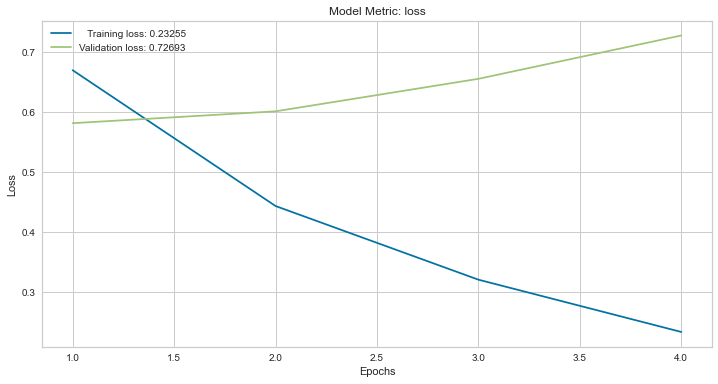

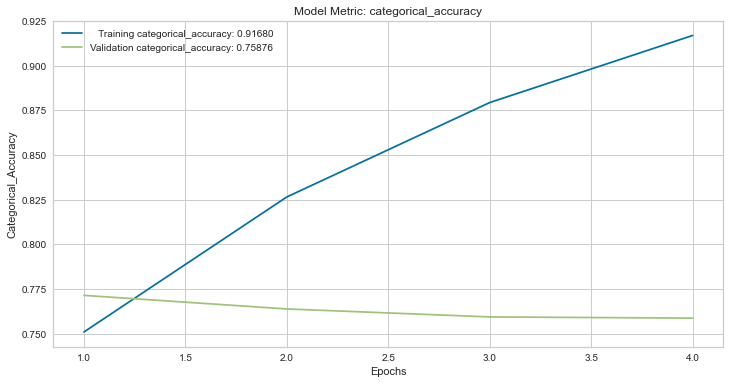

In [126]:
plot_keras_history(history1)

In [127]:
# evaluate and store on score variable
score1 = model1.evaluate(
    X_test_m,                  # features
    Y_test,                  # labels
    batch_size=batch_size,   # batch size
    verbose=1                # the most extended verbose
)

print(score1)
print('\nTest accuracy: {:.3f} %'.format(score1[1]*100))

301/301 [==============================] - 1s 2ms/step - loss: 0.5773 - categorical_accuracy: 0.7745
[0.5773221254348755, 0.7745261192321777]

Test accuracy: 77.453 %


## Embeddings Self_Trained

### Checking the length of each sequence

In [128]:
# Embeddings dimension of vectors
embedding_dim = 300

<AxesSubplot:>

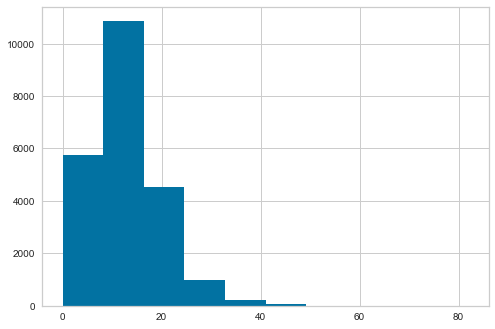

In [129]:
pd.Series([len(s) for s in seq_train]).hist()

<AxesSubplot:ylabel='Density'>

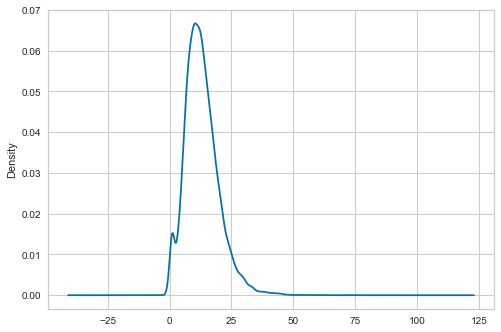

In [130]:
pd.Series([len(i) for i in seq_train]).plot.kde()

## Padding

In [131]:
maxlen = 50

x_train = pad_sequences(seq_train,
                      maxlen=maxlen, 
                      padding='post', 
                      truncating='post', # Valuable info is in the beginnig of the sentence. Where to cut the sentence
                      value=0.0)


x_test = pad_sequences(seq_test,
                      maxlen=maxlen, 
                      padding='post', 
                      truncating='post', 
                      value=0.0)


In [132]:
# Setting the model
model_2 = Sequential()
model_2.add(Embedding(input_dim=max_words,
                      output_dim=embedding_dim,
                      embeddings_initializer='uniform',
                      mask_zero=True,
                      input_length=maxlen))

model_2.add(Flatten())

model_2.add(Dense(64, activation='relu'))
# use a dropout layer with with 20% of inputs droped
model_2.add(Dropout(0.4))

model_2.add(Dense(3, activation='softmax'))

print(model_2.summary())

# You can see that the Embedding layer has 500,000 trainable parameters,
# that is 50 parameters for each of the 10K words.

model_2.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['acc'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 300)           4500000   
_________________________________________________________________
flatten (Flatten)            (None, 15000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                960064    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 195       
Total params: 5,460,259
Trainable params: 5,460,259
Non-trainable params: 0
_________________________________________________________________
None


In [133]:
monitor = 'val_loss'
model_fname = 'model.h2'

callback2 = [
    EarlyStopping(monitor=monitor,
                 patience=4,
                 verbose=1,
                 restore_best_weights=True),
    
    # Save the model after every epoch of the monitor quantity improves
    ModelCheckpoint(filepath=model_fname,
                    monitor=monitor,
                    save_best_only=True,
                    save_weights_only=True,
                    verbose=1),
    
]

In [134]:
history2 = model_2.fit(x_train,
                      Y_train,
                      epochs=nb_epoch,
                      batch_size=batch_size,
                      validation_split=0.2,
                      callbacks=callback2)

Epoch 1/20
561/561 [==============================] - 31s 53ms/step - loss: 0.6387 - acc: 0.7564 - val_loss: 0.5774 - val_acc: 0.7686

Epoch 00001: val_loss improved from inf to 0.57740, saving model to model.h2
Epoch 2/20
561/561 [==============================] - 30s 53ms/step - loss: 0.2852 - acc: 0.8952 - val_loss: 0.7304 - val_acc: 0.7492

Epoch 00002: val_loss did not improve from 0.57740
Epoch 3/20
561/561 [==============================] - 29s 51ms/step - loss: 0.0628 - acc: 0.9809 - val_loss: 1.0457 - val_acc: 0.7458

Epoch 00003: val_loss did not improve from 0.57740
Epoch 4/20
561/561 [==============================] - 30s 53ms/step - loss: 0.0243 - acc: 0.9942 - val_loss: 1.2696 - val_acc: 0.7463

Epoch 00004: val_loss did not improve from 0.57740
Epoch 5/20
561/561 [==============================] - 30s 53ms/step - loss: 0.0131 - acc: 0.9972 - val_loss: 1.3414 - val_acc: 0.7443
Restoring model weights from the end of the best epoch.

Epoch 00005: val_loss did not improve f

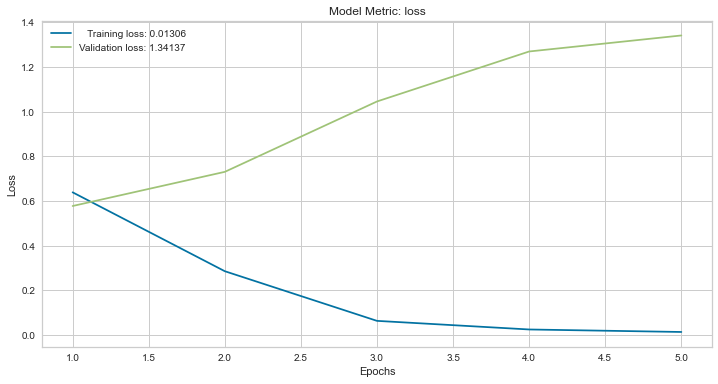

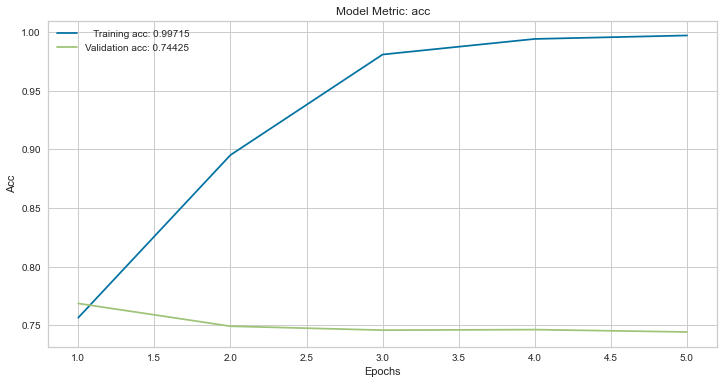

In [135]:
plot_keras_history(history2)

In [136]:
score2 = model_2.evaluate(
    x_test,                  # features
    Y_test,                  # labels
    batch_size=batch_size,   # batch size
    verbose=1                # the most extended verbose
)

print(score2)

print('\nTest accuracy: {:.3f} %'.format(score2[1]*100))

301/301 [==============================] - 1s 4ms/step - loss: 0.5728 - acc: 0.7708
[0.5728492736816406, 0.7707769274711609]

Test accuracy: 77.078 %


### Glove Embeddings - Loading Glove Pre-Trained Embeddings

In [137]:
def load_glove_embeddings(dim: int = 100) -> dict:
    """
    Function that loads glove embeddings. 

    :param dim: The embeddings size (dimensions)
    :return:
    """
    print('Loading word vectors')

    embed_index = dict()  # We create a dictionary of word -> embedding

    fname = 'glove.6B.{}d.txt'.format(dim)

    f = open(fname, encoding="utf8")  # Open file

    # In the dataset, each line represents a new word embedding
    # The line starts with the word and the embedding values follow
    for line in tqdm(f, desc='Loading Embeddings', unit='word'):
        values = line.split()
        # The first value is the word, the rest are the values of the embedding
        word = values[0]
        # Load embedding
        embedding = np.asarray(values[1:], dtype='float32')

        # Add embedding to our embedding dictionary
        embed_index[word] = embedding
    f.close()

    print('Found %s word vectors.' % len(embed_index))

    return embed_index

In [138]:
embedding_dim = 300  

embeddings_index = load_glove_embeddings(dim=embedding_dim)

Loading Embeddings: 652word [00:00, 6456.78word/s]

Loading word vectors


Loading Embeddings: 400000word [00:40, 9988.72word/s] 

Found 400000 word vectors.


In [139]:
# Length of the dictionary of the embeddings index with words
len(embeddings_index)

400000

In [140]:
embeddings_index.get('the').shape

(300,)

In [141]:
voc = len(claims_tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(voc)
print(seq_train[0])
print(x_train[0])

24537
[257, 8019, 13448, 50, 13449, 9923, 6746, 3751, 160, 3308, 2721, 238, 9924, 13450, 236]
[  257  8019 13448    50 13449  9923  6746  3751   160  3308  2721   238
  9924 13450   236     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]


In [142]:
print('Train sequences: {}'.format(len(seq_train)))
print('Test sequences: {}'.format(len(seq_test)))

Train sequences: 22402
Test sequences: 9602


In [143]:
x_test.shape

(9602, 50)

In [144]:
print(seq_train[0])

[257, 8019, 13448, 50, 13449, 9923, 6746, 3751, 160, 3308, 2721, 238, 9924, 13450, 236]


In [145]:
print(x_train[0])

[  257  8019 13448    50 13449  9923  6746  3751   160  3308  2721   238
  9924 13450   236     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]


In [146]:
word_index = claims_tokenizer.word_index
print(max_words)
# How many words are there actually. Because we may have requested X most common tokens
# and the total tokens are X/2
nb_words = min(max_words, len(word_index))
print(nb_words)

15000
15000


In [147]:
print(f'X train shape: {x_train.shape}')
print(f'y train shape: {Y_train.shape}')

print(f'X test shape: {x_test.shape}')
print(f'y test shape: {Y_test.shape}')

X train shape: (22402, 50)
y train shape: (22402, 3)
X test shape: (9602, 50)
y test shape: (9602, 3)


In [148]:
def create_embeddings_matrix(emb_index: dict,
                             tokenizer: Tokenizer,
                             emb_dim: int = 100) -> np.ndarray:
    """

    :param emb_index: Embeddings Index
    :param tokenizer: Keras fitted tokenizer.
    :param emb_dim: Embeddings dimension.
    :return: A matrix of shape (nb_words, emb_dim) containing the globe embeddings.
    """
    assert emb_dim in [50, 100, 200, 300]

    # Create a matrix of all embeddings
    # (stacking=concatenating all the vectors)
    all_embs = np.stack(emb_index.values())  # .values() gets the all the arrays from the keys

    # Calculate mean
    emb_mean = all_embs.mean()
    # Calculate standard deviation
    emb_std = all_embs.std()

    print("Embeddings AVG: {} | STD: {}".format(emb_mean, emb_std))

    # We can now create an embedding matrix holding all word vectors.

    word_index = tokenizer.word_index 

    # How many words are there actually. Because we may have requested X most common tokens
    # and the total tokens are X/2
    nb_words = min(max_words, len(word_index))

    # Create a random matrix with the same mean and std as the embeddings

    embedding_matrix = np.random.normal(emb_mean,  # mean
                                        emb_std,  # std
                                        (nb_words, emb_dim)) # shape of the matrix

    # The vectors need to be in the same position as their index.
    # Meaning a word with token 1 needs to be in the second row (rows start with zero) and so on
    
    counter = 0
    
    # Loop over all words in the word index
    for word, i in word_index.items():  # .items() return a tuple with (word, word_index)

        # If we are above the amount of words we want to use we do nothing
        if i >= max_words:
            continue

        # Get the embedding vector for the word
        embedding_vector = emb_index.get(word)

        # If there is an embedding vector, put it in the embedding matrix
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            counter += 1
    
    print(f'Found {counter} pre-trained embeddings out of {nb_words}')
    
    return embedding_matrix

In [149]:
embedding_matrix = create_embeddings_matrix(emb_index=embeddings_index,
                                            tokenizer=claims_tokenizer,
                                            emb_dim=embedding_dim)

C:\Users\ngkiz\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Embeddings AVG: -0.003905011573806405 | STD: 0.3817702829837799
Found 10660 pre-trained embeddings out of 15000


In [150]:
len(embedding_matrix)

15000

### Model with Glove Embeddings

In [151]:
print(voc)

24537


In [152]:
model_3 = Sequential()
model_3.add(Embedding(max_words,
                      embedding_dim,
                      input_length=maxlen,
                      weights=[embedding_matrix],
                      trainable=False))

model_3.add(Flatten())
model_3.add(Dense(128, activation='relu'))
model_3.add(Dropout(0.4))
model_3.add(Dense(128, activation='relu'))
model_3.add(Dropout(0.4))
model_3.add(Dense(3, activation='softmax'))
print(model_3.summary())

# Notice that we now have far fewer trainable parameters.
model_3.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=[
                    metrics.categorical_accuracy
                ])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           4500000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 15000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1920128   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                

In [153]:
monitor = 'val_loss'

callback3 = [
    EarlyStopping(monitor=monitor,
                 patience=3,
                 verbose=1,
                 restore_best_weights=True)
]

In [154]:
history3 = model_3.fit(x_train, Y_train,
                       epochs=nb_epoch,
                       batch_size=batch_size,
                       validation_split=0.2,
                      callbacks=callback3)

Epoch 1/20
561/561 [==============================] - 7s 11ms/step - loss: 0.8730 - categorical_accuracy: 0.6870 - val_loss: 0.7980 - val_categorical_accuracy: 0.7074
Epoch 2/20
561/561 [==============================] - 6s 10ms/step - loss: 0.8127 - categorical_accuracy: 0.6974 - val_loss: 0.7987 - val_categorical_accuracy: 0.7079
Epoch 3/20
561/561 [==============================] - 6s 10ms/step - loss: 0.8147 - categorical_accuracy: 0.6973 - val_loss: 0.7987 - val_categorical_accuracy: 0.7072
Epoch 4/20
561/561 [==============================] - 6s 10ms/step - loss: 0.8136 - categorical_accuracy: 0.6975 - val_loss: 0.7986 - val_categorical_accuracy: 0.7072
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping


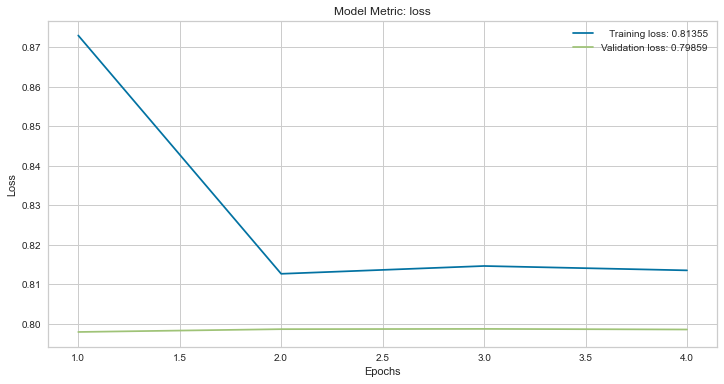

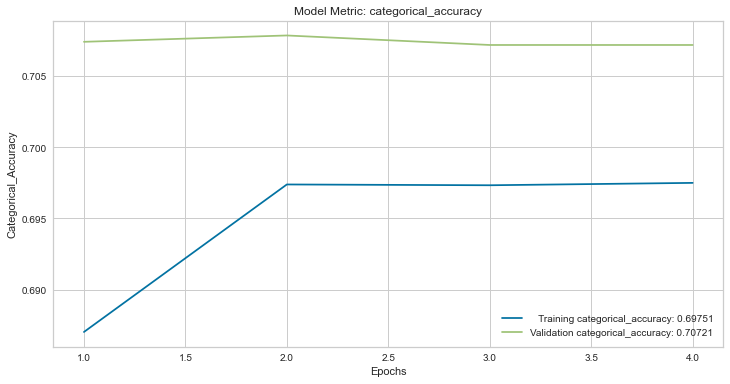

In [155]:
plot_keras_history(history3)

In [156]:
score3 = model_3.evaluate(
    x_test,                  # features
    Y_test,                  # labels
    batch_size=batch_size,   # batch size
    verbose=1     
)


print('\nTest accuracy: {:.3f} %'.format(score3[1]*100))

301/301 [==============================] - 1s 3ms/step - loss: 0.8094 - categorical_accuracy: 0.6991

Test accuracy: 69.913 %


### Convolutional (1D) Neura Networks (CNN)

In [159]:
filters = 25 # Number of filters

kernel_size = 3 # Trigrams

In [160]:
model_4 = Sequential()

model_4.add(Embedding(max_words,
                      embedding_dim,
                      input_length=maxlen,
                      weights=[embedding_matrix]))

#model_1.add(Flatten())
model_4.add(Conv1D(filters,
                  kernel_size,
                  padding='valid',
                  activation='relu',
                  strides=1))

model_4.add(GlobalMaxPooling1D())

model_4.add(Dense(64, activation='relu'))
model_4.add(Dropout(0.4))
model_4.add(Dense(3, activation='softmax'))
print(model_4.summary())

# Notice that we now have far fewer trainable parameters.
model_4.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=[
                    metrics.categorical_accuracy
                ])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 300)           4500000   
_________________________________________________________________
conv1d (Conv1D)              (None, 48, 25)            22525     
_________________________________________________________________
global_max_pooling1d (Global (None, 25)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                1664      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 195       
Total params: 4,524,384
Trainable params: 4,524,384
Non-trainable params: 0
____________________________________________

In [161]:
monitor = 'val_loss'
model_fname = 'model.h4'
callback4 = [
    EarlyStopping(monitor=monitor,
                 patience=4,
                 verbose=1,
                 restore_best_weights=True),
    
    # Save the model after every epoch of the monitor quantity improves
    ModelCheckpoint(filepath=model_fname,
                    monitor=monitor,
                    save_best_only=True,
                    save_weights_only=True,
                    verbose=1),
]

In [162]:
history4 = model_4.fit(x_train, Y_train,
                       epochs=50,
                       batch_size=batch_size,
                       validation_split=0.2,
                      callbacks=callback4)

Epoch 1/50
561/561 [==============================] - 31s 55ms/step - loss: 0.6816 - categorical_accuracy: 0.7403 - val_loss: 0.5918 - val_categorical_accuracy: 0.7677

Epoch 00001: val_loss improved from inf to 0.59178, saving model to model.h4
Epoch 2/50
561/561 [==============================] - 30s 53ms/step - loss: 0.4825 - categorical_accuracy: 0.8101 - val_loss: 0.6020 - val_categorical_accuracy: 0.7739

Epoch 00002: val_loss did not improve from 0.59178
Epoch 3/50
561/561 [==============================] - 30s 54ms/step - loss: 0.2996 - categorical_accuracy: 0.8856 - val_loss: 0.7658 - val_categorical_accuracy: 0.7610

Epoch 00003: val_loss did not improve from 0.59178
Epoch 4/50
561/561 [==============================] - 31s 55ms/step - loss: 0.1529 - categorical_accuracy: 0.9476 - val_loss: 0.9023 - val_categorical_accuracy: 0.7476

Epoch 00004: val_loss did not improve from 0.59178
Epoch 5/50
561/561 [==============================] - 31s 55ms/step - loss: 0.0681 - categoric

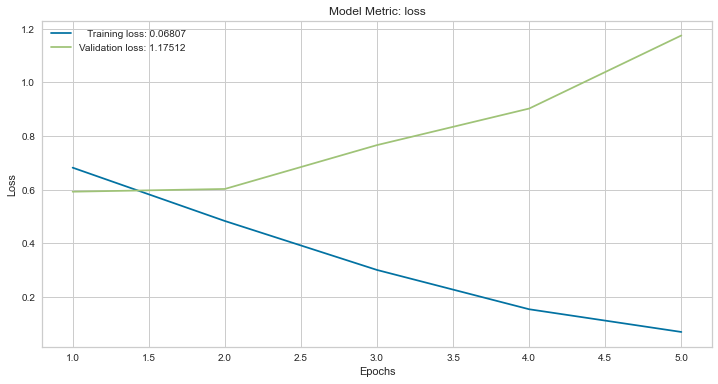

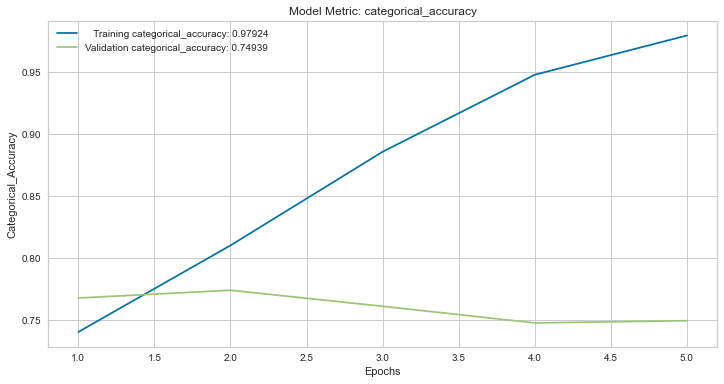

In [163]:
plot_keras_history(history4)

In [164]:
score4 = model_4.evaluate(
    x_test,                  # features
    Y_test,                  # labels
    batch_size=32,   # batch size
    verbose=1     
)


print('\nTest accuracy: {:.3f} %'.format(score4[1]*100))

301/301 [==============================] - 2s 6ms/step - loss: 0.5937 - categorical_accuracy: 0.7648

Test accuracy: 76.484 %


In [165]:
model_5 = Sequential()

model_5.add(Embedding(max_words,
                      embedding_dim,
                      input_length=maxlen,
                      weights=[embedding_matrix]))

#model_1.add(Flatten())
model_5.add(Conv1D(filters,
                  kernel_size,
                  padding='valid',
                  activation='relu'))

model_5.add(GlobalMaxPooling1D())

model_5.add(Dense(64, activation='relu'))
model_5.add(Dropout(0.4))
model_5.add(Dense(3, activation='softmax'))
print(model_5.summary())

# Notice that we now have far fewer trainable parameters.
model_5.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=[
                    metrics.categorical_accuracy
                ])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 300)           4500000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 48, 25)            22525     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 25)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                1664      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 195       
Total params: 4,524,384
Trainable params: 4,524,384
Non-trainable params: 0
____________________________________________

In [168]:
monitor = 'val_loss'
model_fname = 'model.h5'
callback5 = [
    EarlyStopping(monitor=monitor,
                 patience=4,
                 verbose=1,
                 restore_best_weights=True),
    
    # Save the model after every epoch of the monitor quantity improves
    ModelCheckpoint(filepath=model_fname,
                    monitor=monitor,
                    save_best_only=True,
                    save_weights_only=True,
                    verbose=1),
]

In [169]:
history5 = model_5.fit(x_train, Y_train,
                       epochs=50,
                       batch_size=batch_size,
                       validation_split=0.2,
                      callbacks=callback5)

Epoch 1/50
561/561 [==============================] - 31s 54ms/step - loss: 0.5125 - categorical_accuracy: 0.8007 - val_loss: 0.5877 - val_categorical_accuracy: 0.7583

Epoch 00001: val_loss improved from inf to 0.58775, saving model to model.h5
Epoch 2/50
561/561 [==============================] - 30s 53ms/step - loss: 0.3307 - categorical_accuracy: 0.8797 - val_loss: 0.6661 - val_categorical_accuracy: 0.7498

Epoch 00002: val_loss did not improve from 0.58775
Epoch 3/50
561/561 [==============================] - 29s 52ms/step - loss: 0.1681 - categorical_accuracy: 0.9429 - val_loss: 0.9060 - val_categorical_accuracy: 0.7509

Epoch 00003: val_loss did not improve from 0.58775
Epoch 4/50
561/561 [==============================] - 30s 53ms/step - loss: 0.0812 - categorical_accuracy: 0.9749 - val_loss: 1.1294 - val_categorical_accuracy: 0.7501

Epoch 00004: val_loss did not improve from 0.58775
Epoch 5/50
561/561 [==============================] - 30s 54ms/step - loss: 0.0472 - categoric

In [170]:
score5 = model_5.evaluate(
    x_test,                  # features
    Y_test,                  # labels
    batch_size=32,   # batch size
    verbose=1     
)


print('\nTest accuracy: {:.3f} %'.format(score5[1]*100))

301/301 [==============================] - 1s 3ms/step - loss: 0.5847 - categorical_accuracy: 0.7639

Test accuracy: 76.390 %


## PLOTS - ROC - Confusion matrixes

In [171]:
def plot_multi_class_roc_auc_curves(nb_classes, y_true, y_pred_score, lw: int = 2):
    """
    ROC, AUC for a categorical classifier
    
    ROC curve extends to problems with three or more classes with what is known as the one-vs-all approach.
    For instance, if we have three classes, we will create three ROC curves,

    For each class, we take it as the positive class and group the rest classes jointly as the negative class.

    Class 1 vs classes 2&3
    Class 2 vs classes 1&3
    Class 3 vs classes 1&2

    :param nb_classes:
    :param y_true:
    :param y_pred_score:
    :param lw:
    :return:
    """

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(nb_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_score[:, i])

        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred_score.ravel())

    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nb_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(nb_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= nb_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(1)
    plt.plot(fpr["micro"],
             tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink',
             linestyle=':',
             linewidth=4)

    plt.plot(fpr["macro"],
             tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy',
             linestyle=':',
             linewidth=4)

    colors = cycle(['aqua',
                    'darkorange',
                    'cornflowerblue'])

    for i, color in zip(range(nb_classes), colors):
        plt.plot(fpr[i],
                 tpr[i],
                 color=color,
                 lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1],
             [0, 1],
             'k--',
             lw=lw)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")



In [172]:
def print_confusion_matrix(y_true,
                           y_pred,
                           class_names: List[str],
                           figsize: Tuple[int, int] = (10, 7),
                           fontsize: int = 14) -> pd.DataFrame:
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heat-map.

    For something more extraordinary check this repo:
    https://github.com/wcipriano/pretty-print-confusion-matrix


    :param class_names:  An ordered list of class names
    :param figsize: A 2-long tuple, the first value determining the horizontal size of the outputted
                    figure, the second determining the vertical size. Defaults to (10,7).
    :param fontsize: Font size for axes labels. Defaults to 14.
    :return: The confusion matrix as a dataset
    """
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

    df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

    fig = plt.figure(figsize=figsize)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    except ValueError:

        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                                 rotation=0,
                                 ha='right',
                                 fontsize=fontsize)

    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                                 rotation=45,
                                 ha='right',
                                 fontsize=fontsize)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return df_cm

## Classification Reports - Confustion Matrixes - ROC Curves

### Model 1 MLP

In [173]:
y_test_pred_1 = model1.predict_classes(X_test_m)
y_test_pred_1

C:\Users\ngkiz\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

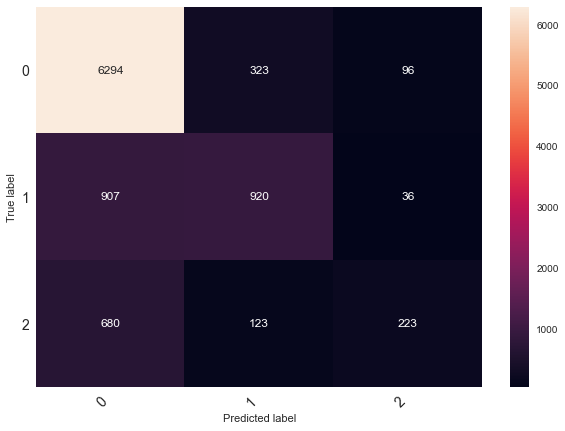

,0,1,2
0,6294,323,96
1,907,920,36
2,680,123,223


In [174]:
print_confusion_matrix(y_true=Y_test.argmax(axis=1),
                      y_pred=y_test_pred_1,
                      class_names=range(nb_classes))

In [175]:
# conf_mat1 = confusion_matrix(Y_test.argmax(axis=1),
#                             y_test_pred_1)

# pd.DataFrame(conf_mat1)

In [176]:
print(classification_report(Y_test.argmax(axis=1),
                            y_test_pred_1,
                            digits=4))

              precision    recall  f1-score   support

           0     0.7986    0.9376    0.8625      6713
           1     0.6735    0.4938    0.5698      1863
           2     0.6282    0.2173    0.3230      1026

    accuracy                         0.7745      9602
   macro avg     0.7001    0.5496    0.5851      9602
weighted avg     0.7561    0.7745    0.7481      9602



In [177]:
y_score1_prob = model1.predict(X_test_m)
y_score1_prob

array([[0.9815137 , 0.00995322, 0.00853315],
       [0.94652224, 0.00534297, 0.04813487],
       [0.879576  , 0.09319068, 0.02723335],
       ...,
       [0.4984674 , 0.33133715, 0.1701955 ],
       [0.9456089 , 0.02373007, 0.03066112],
       [0.9445798 , 0.01102388, 0.04439631]], dtype=float32)

<ipython-input-171-5e34eafa2961>:45: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


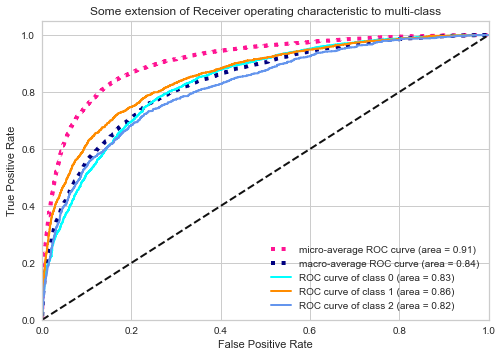

In [178]:
plot_multi_class_roc_auc_curves(nb_classes=nb_classes,
                                y_true=Y_test,
                                y_pred_score=y_score1_prob)

### Model 2

In [179]:
y_test_pred_2 = model_2.predict_classes(x_test)
y_test_pred_2

C:\Users\ngkiz\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [100]:
# conf_mat2 = confusion_matrix(Y_test.argmax(axis=1),
#                             y_test_pred_2)

# pd.DataFrame(conf_mat2)

,0,1,2
0,6104,475,134
1,728,1085,50
2,575,180,271


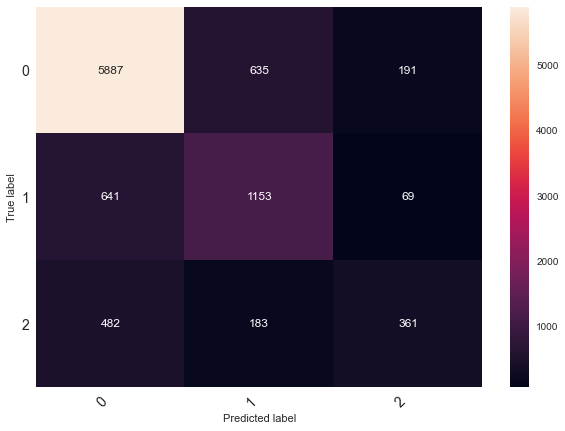

,0,1,2
0,5887,635,191
1,641,1153,69
2,482,183,361


In [180]:
print_confusion_matrix(y_true=Y_test.argmax(axis=1),
                      y_pred=y_test_pred_2,
                      class_names=range(nb_classes))

In [181]:
print(classification_report(Y_test.argmax(axis=1),
                            y_test_pred_2,
                            digits=4))

              precision    recall  f1-score   support

           0     0.8398    0.8770    0.8580      6713
           1     0.5850    0.6189    0.6015      1863
           2     0.5813    0.3519    0.4384      1026

    accuracy                         0.7708      9602
   macro avg     0.6687    0.6159    0.6326      9602
weighted avg     0.7627    0.7708    0.7634      9602



In [182]:
y_score2_prob = model_2.predict(x_test)
y_score2_prob

array([[0.9652991 , 0.01485729, 0.01984362],
       [0.9949137 , 0.00102805, 0.00405826],
       [0.90541595, 0.074723  , 0.01986109],
       ...,
       [0.5533731 , 0.3911065 , 0.05552038],
       [0.98612463, 0.00708592, 0.00678956],
       [0.96551424, 0.00610316, 0.02838255]], dtype=float32)

<ipython-input-171-5e34eafa2961>:45: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


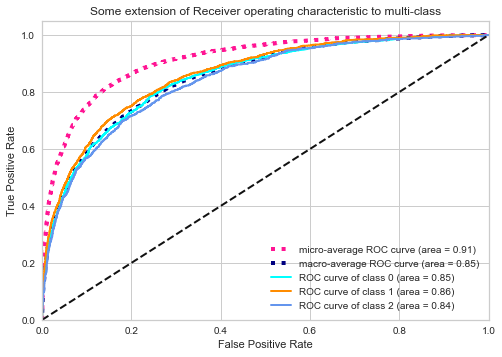

In [183]:
plot_multi_class_roc_auc_curves(nb_classes=nb_classes,
                                y_true=Y_test,
                                y_pred_score=y_score2_prob)

### Model 3

In [184]:
y_test_pred_3 = model_3.predict_classes(x_test)
y_test_pred_3

C:\Users\ngkiz\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [185]:
# conf_mat3 = confusion_matrix(Y_test.argmax(axis=1),
#                             y_test_pred_3)

# pd.DataFrame(conf_mat3)

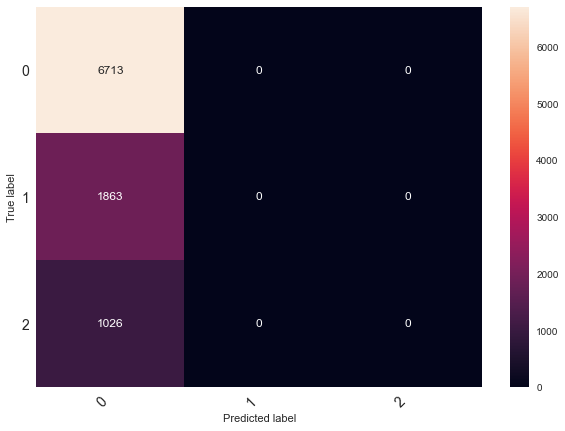

,0,1,2
0,6713,0,0
1,1863,0,0
2,1026,0,0


In [186]:
print_confusion_matrix(y_true=Y_test.argmax(axis=1),
                      y_pred=y_test_pred_3,
                      class_names=range(nb_classes))

In [187]:
print(classification_report(Y_test.argmax(axis=1),
                            y_test_pred_3,
                            digits=4))

              precision    recall  f1-score   support

           0     0.6991    1.0000    0.8229      6713
           1     0.0000    0.0000    0.0000      1863
           2     0.0000    0.0000    0.0000      1026

    accuracy                         0.6991      9602
   macro avg     0.2330    0.3333    0.2743      9602
weighted avg     0.4888    0.6991    0.5753      9602



C:\Users\ngkiz\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [188]:
y_score3_prob = model_3.predict(x_test)
y_score3_prob

array([[0.7138269 , 0.18310045, 0.1030727 ],
       [0.7138269 , 0.18310045, 0.1030727 ],
       [0.7138269 , 0.18310045, 0.1030727 ],
       ...,
       [0.7138269 , 0.18310045, 0.1030727 ],
       [0.7138269 , 0.18310045, 0.1030727 ],
       [0.7138269 , 0.18310045, 0.1030727 ]], dtype=float32)

<ipython-input-171-5e34eafa2961>:45: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


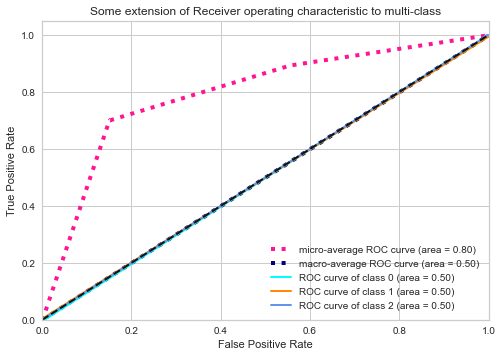

In [189]:
plot_multi_class_roc_auc_curves(nb_classes=nb_classes,
                                y_true=Y_test,
                                y_pred_score=y_score3_prob)

In [190]:
x_test.shape

(9602, 50)

### Model 4

In [191]:
y_score4_prob = model_4.predict(x_test)
y_score4_prob

array([[0.9643632 , 0.0134801 , 0.02215668],
       [0.92811567, 0.01903773, 0.05284663],
       [0.7858173 , 0.17979473, 0.03438793],
       ...,
       [0.70734346, 0.2713872 , 0.02126939],
       [0.9964675 , 0.00121933, 0.00231311],
       [0.902582  , 0.03253024, 0.06488785]], dtype=float32)

In [192]:
y_test_pred_4 = model_4.predict_classes(x_test)
y_test_pred_4

C:\Users\ngkiz\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

<ipython-input-171-5e34eafa2961>:45: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


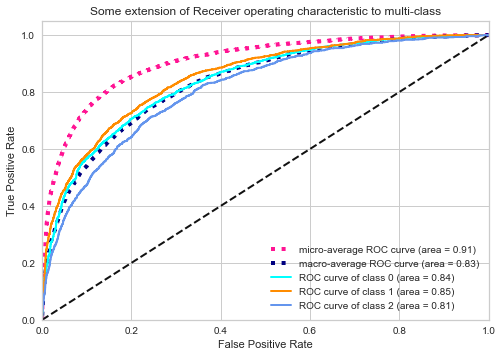

In [193]:
plot_multi_class_roc_auc_curves(nb_classes=nb_classes,
                                y_true=Y_test,
                                y_pred_score=y_score4_prob)

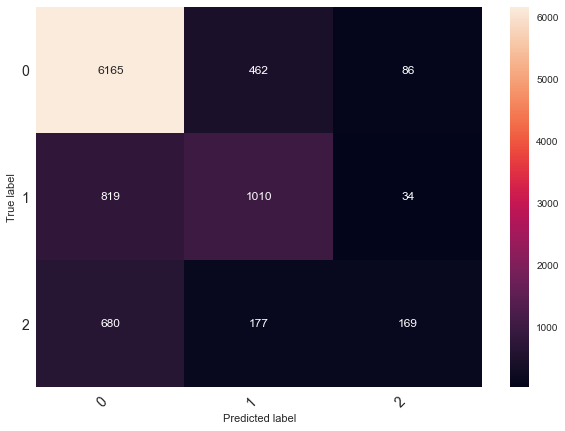

,0,1,2
0,6165,462,86
1,819,1010,34
2,680,177,169


In [194]:
print_confusion_matrix(y_true=Y_test.argmax(axis=1),
                      y_pred=y_test_pred_4,
                      class_names=range(nb_classes))

In [195]:
print(classification_report(Y_test.argmax(axis=1),
                            y_test_pred_4,
                            digits=4))

              precision    recall  f1-score   support

           0     0.8044    0.9184    0.8576      6713
           1     0.6125    0.5421    0.5752      1863
           2     0.5848    0.1647    0.2570      1026

    accuracy                         0.7648      9602
   macro avg     0.6672    0.5417    0.5633      9602
weighted avg     0.7437    0.7648    0.7386      9602

